# Loan Approval Decision Support Analysis

## Objective

The objective of this analysis is to evaluate how different classification models can support loan approval decisions by balancing predictive performance, interpretability, and financial risk. Rather than optimizing for accuracy alone, the focus is on understanding model tradeoffs and how decision thresholds can be adjusted to align predictions with real-world business and risk considerations.


## Context
Loan approval decisions involve tradeoffs between approving qualified applicants and minimizing default risk. In practice, predictive models are often used as decision-support tools to flag applications for approval or manual review rather than as fully automated systems.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Data Overview
The dataset contains historical loan application records with applicant demographic, financial, and loan-related features. The target variable indicates whether a loan was approved or rejected.

Prior to modeling, the data was reviewed for missing values, categorical variables were encoded, and features were prepared for use in classification models.

The target variable is moderately imbalanced, which is important to consider when interpreting model performance.

In [3]:
df = pd.read_csv('data/Loan-Approval-Prediction.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    str    
 1   Gender             601 non-null    str    
 2   Married            611 non-null    str    
 3   Dependents         599 non-null    str    
 4   Education          614 non-null    str    
 5   Self_Employed      582 non-null    str    
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    str    
 12  Loan_Status        614 non-null    str    
dtypes: float64(4), int64(1), str(8)
memory usage: 62.5 KB


The dataset contains 480 records with a mix of numeric and categorical features relevant to loan approval decisions.

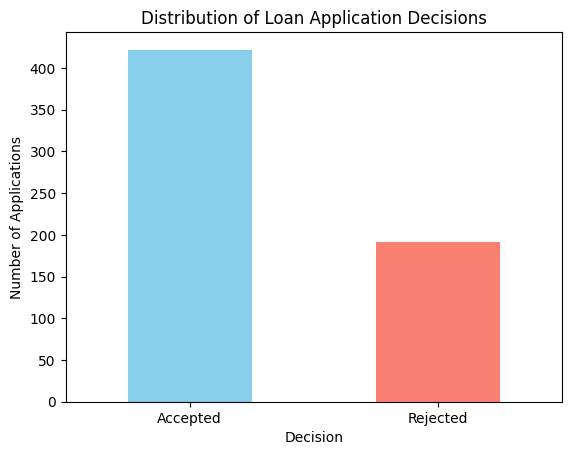

In [5]:
status_counts = (
    df['Loan_Status']
    .replace({'Y': 'Accepted', 'N': 'Rejected'})
    .value_counts()
)

fig, ax = plt.subplots()

status_counts.plot(kind='bar', color=['skyblue', 'salmon'], ax=ax)

ax.set_title("Distribution of Loan Application Decisions")
ax.set_xlabel("Decision")
ax.set_ylabel("Number of Applications")

plt.xticks(rotation=0)
plt.show()


## Data Preparation
To prepare the data for modeling, missing values were handled and categorical variables were encoded. The dataset was then split into input features (X) and the target variable (y) to ensure models only used information available at the time of the loan decision.


In [6]:
df['Loan_Status'] = df.Loan_Status.replace('N', 0).replace('Y',1).astype(int)
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Married'] = df['Married'].map({'No': 0, 'Yes': 1})
df['Self_Employed'] = df['Self_Employed'].map({'No': 0, 'Yes': 1})
df['Education'] = df.Education.replace('Not Graduate', 0).replace('Graduate',1).astype(int)
df['Dependents'] = df['Dependents'].map({'0': 0, '1': 1, '2': 2, '3+': 3})
df['Property_Area'] = df.Property_Area.replace('Rural', 0).replace('Semiurban',1).replace('Urban',2).astype(int)

df = df.dropna()

df = df[df['ApplicantIncome'] <= 30000]

In [7]:
X = df.drop(columns=["Loan_Status", "Loan_ID"])
y = df["Loan_Status"]

In [8]:
rs=123

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=rs
    )

In [9]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling and Evaluation
Multiple classification models were evaluated to assess their suitability for supporting loan approval decisions. Rather than focusing solely on overall accuracy, evaluation emphasized class-specific performance metrics and error tradeoffs relevant to financial risk.


### Logistic Regression
Logistic regression was used as a baseline model due to its interpretability and common use in credit decisioning.


In [10]:
lr = LogisticRegression(
    random_state=rs,
    solver='lbfgs',
    max_iter=5000,
    class_weight='balanced'
)

lr.fit(X_train_scaled, y_train)
lr_preds = lr.predict(X_test_scaled)

In [11]:
print(classification_report(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.52      0.48      0.50        29
           1       0.78      0.80      0.79        66

    accuracy                           0.71        95
   macro avg       0.65      0.64      0.65        95
weighted avg       0.70      0.71      0.70        95



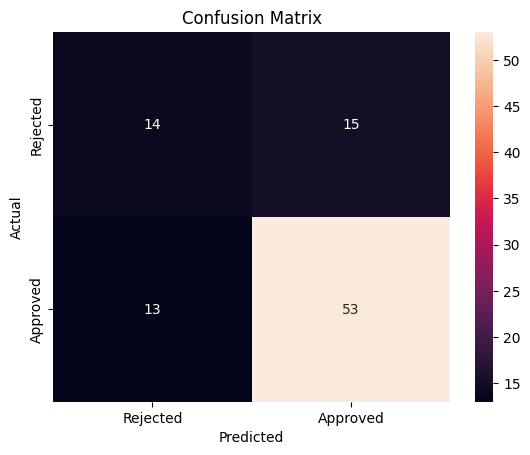

In [12]:
cm = confusion_matrix(y_test, lr_preds)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=["Rejected", "Approved"],
    yticklabels=["Rejected", "Approved"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

At the default 0.50 decision threshold, Logistic Regression achieved 71% accuracy with 48% recall for higher-risk applicants.

### Random Forest Classifier

A Random Forest model was evaluated to compare performance against logistic regression. While less interpretable, tree-based models can capture non-linear relationships and interactions between features, which may improve predictive performance in complex decision settings.

In [13]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=rs,
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

In [14]:
print(classification_report(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.70      0.48      0.57        29
           1       0.80      0.91      0.85        66

    accuracy                           0.78        95
   macro avg       0.75      0.70      0.71        95
weighted avg       0.77      0.78      0.77        95



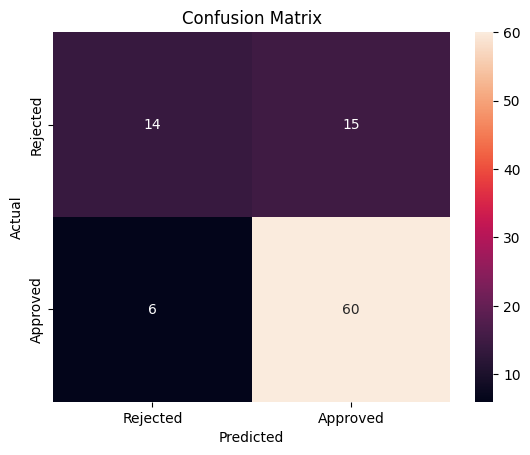

In [15]:
cm = confusion_matrix(y_test, rf_preds)

plt.figure()
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=["Rejected", "Approved"],
    yticklabels=["Rejected", "Approved"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

At the default threshold, Random Forest acheived 78% accuracy with 48% recall for higher-risk applicants.

### Model Comparison and Risk Tradeoffs

The Random Forest model reduced false rejections and therefore accepted more low-risk applicants than logistic regression. This also means that Random Forest has a higher accuracy of 78% opposed to 71%. Using the default thresholds, Random Forest is a stronger model as there are no differences in their performances aside than this.

## Cost-Sensitive Decision Threshold Analysis
Real-world loan approval decisions require explicit consideration of the costs associated with different types of errors. In particular, false approvals often carry greater financial risk than false rejections. This section evaluates how adjusting the decision threshold influences approval rates and cost tradeoffs, reframing model predictions as decision-support tools.

In [16]:
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]

In [17]:
def evaluate_thresholds(y_true, y_probs, thresholds, cost_fp=5, cost_fn=1):
    results = []

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        total_cost = (fp * cost_fp) + (fn * cost_fn)
        approval_rate = (tp + fp) / len(y_true)

        results.append({
            "Threshold": t,
            "False Approvals (FP)": fp,
            "False Rejections (FN)": fn,
            "Approval Rate": approval_rate,
            "Estimated Cost": total_cost
        })

    return pd.DataFrame(results)


In [18]:
thresholds = np.arange(0.2, 0.8, 0.05)

lr_results = evaluate_thresholds(y_test, lr_probs, thresholds)
rf_results = evaluate_thresholds(y_test, rf_probs, thresholds)

In [19]:
lr_results.sort_values("Estimated Cost")

,Threshold,False Approvals (FP),False Rejections (FN),Approval Rate,Estimated Cost
11,0.75,1,60,0.073684,65
12,0.80,0,66,0.000000,66
8,0.60,10,22,0.568421,72
10,0.70,7,40,0.347368,75
7,0.55,12,17,0.642105,77
9,0.65,10,32,0.463158,82
6,0.50,15,13,0.715789,88
0,0.20,18,4,0.842105,94
1,0.25,18,4,0.842105,94
2,0.30,18,4,0.842105,94


Although the lowest estimated cost occurred at a threshold of 0.75, this resulted in an approval rate below 10%, effectively restricting nearly all lending activity. While financially conservative, such a policy would be operationally unrealistic.

More moderate thresholds (0.55–0.60) reduced estimated cost relative to the default while maintaining sustainable approval rates. This highlights the distinction between mathematical cost minimization and practical policy implementation in credit decisioning.

In [20]:
rf_results.sort_values("Estimated Cost")

,Threshold,False Approvals (FP),False Rejections (FN),Approval Rate,Estimated Cost
11,0.75,8,26,0.505263,66
10,0.70,10,20,0.589474,70
12,0.80,7,35,0.400000,70
9,0.65,12,16,0.652632,76
6,0.50,15,6,0.789474,81
7,0.55,15,10,0.747368,85
8,0.60,15,12,0.726316,87
4,0.40,17,4,0.831579,89
5,0.45,17,4,0.831579,89
1,0.25,18,4,0.842105,94


Similar to logistic regression the lowest estimated cost produced by Random Forest occured at a threshold of 0.75. Unlike logistic regression, the approval rate did not drop as drastically as the threshold increased. Due to its low cost and false approvals, the threshold of 0.75 aligns most strongly with financially covservative ideals.

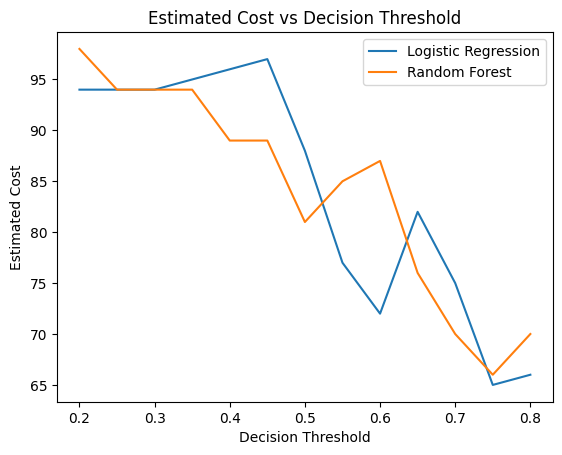

In [21]:
plt.figure()
plt.plot(lr_results["Threshold"], lr_results["Estimated Cost"], label= "Logistic Regression")
plt.plot(rf_results["Threshold"], rf_results["Estimated Cost"], label="Random Forest")
plt.xlabel("Decision Threshold")
plt.ylabel("Estimated Cost")
plt.title("Estimated Cost vs Decision Threshold")
plt.legend()
plt.show()

The plot of estimated cost versus decision threshold shows that both logistic regression and random forest follow a similar pattern. At very low thresholds, costs are high because too many loans are approved, leading to a large number of false approvals, while at very high thresholds, costs are low as high rates of applicants are denied (risky or not). Both models reach their lowest estimated cost around thresholds of 0.75.

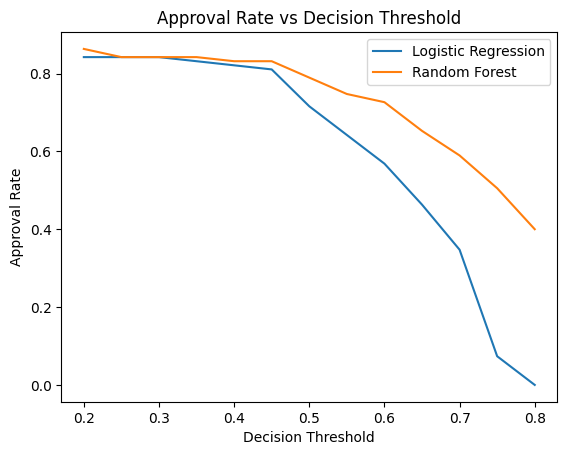

In [22]:
plt.figure()
plt.plot(lr_results["Threshold"], lr_results["Approval Rate"], label= "Logistic Regression")
plt.plot(rf_results["Threshold"], rf_results["Approval Rate"], label="Random Forest")
plt.xlabel("Decision Threshold")
plt.ylabel("Approval Rate")
plt.title("Approval Rate vs Decision Threshold")
plt.legend()
plt.show()

This plot demonstrates why the best threshold for logistic regression and Random Forest may not be the same. Logistic regression's approval rate rapidly falls starting at about 0.5. This suggests that the stronger threshold for logistic regression models may be around 0.55-0.60. These thresholds have an acceptable approval rate and low estimated cost. The Random Forest model does not experience a decrease in approval rate as rapdily. This offers the opportunity to use a higher threshold like 0.70-0.75 without jeopardizing income through false rejections as much.

In [36]:
best_threshold = 0.55
best_preds = (lr_probs >= best_threshold).astype(int)
print(classification_report(y_test, best_preds))

              precision    recall  f1-score   support

           0       0.50      0.59      0.54        29
           1       0.80      0.74      0.77        66

    accuracy                           0.69        95
   macro avg       0.65      0.66      0.66        95
weighted avg       0.71      0.69      0.70        95



In [33]:
best_threshold = 0.70
best_preds = (rf_probs >= best_threshold).astype(int)
print(classification_report(y_test, best_preds))

              precision    recall  f1-score   support

           0       0.49      0.66      0.56        29
           1       0.82      0.70      0.75        66

    accuracy                           0.68        95
   macro avg       0.65      0.68      0.66        95
weighted avg       0.72      0.68      0.69        95



### Interpretation

The cost-senstitive threshold analysis reveals meaningful differences in how each model supports decision-making. Logistic regression and random forest show similar senstivity to threshold changes regarding estimated cost. The models reflect high estimated costs when the threshold is low and vice versa. 

In constrast, the models have differing behavior when it comes to approval rates. Increasing the threshold more negatively impacts the logistic regression model than the Random Forest. This suggests that the Random Forest could use a higher threshold without sacrificing as many worthy applicants.

These results demonstate how model choice and decision thresholds jointly influence approval outcomes, reinforcing the role of predictive models as adjustable decision-support tools rather than fully automated systems.

## Practical Application

This analysis demonstrates how predictive models can be used to support, rather than automate, loan approval decisions. By adjusting decision thresholds based on the relative cost of false approvals and false rejections, institutions can align model outputs with their risk tolerance and business priorities. In practice, such models could be used to flag higher-risk applications for additional review while allowing lower-risk applications to proceed through standard approval workflows.